![](http://wiki.swarma.net/images/e/e7/集智AI学园首页左上角logo_2017.8.17.png)

# AI 有嘻哈 

最近“中国有嘻哈”特别火。

我也来跟风，所以本周的 NLP 教程是拿循环神经网络（RNN）来生成嘻哈歌词。

先让我们看看一个简单的深度神经网络模型，能生成什么样的“嘻哈歌词”。

```bash
我的世界
能够有
看透
我的兄弟在我身边
每个人
或许他们是我的眼
我的能够将别约别约我

在这种角度
我就是你你的帮派
他们的声音
原本地方叫
别约你约我
别约我
别约我
```

还不错哈！

## 原理

简单来说，中文句子中的每个字在统计上是相关的。比如对于“多想你陪我透透气”这句话，如果我们知道第一个字“多”，那下一字有可能是“想”；如果知道前两个字“多想”，那么第三个字是“你”的可能性就大些，以此类推，如果知道“多想你陪我透透”，那么最后一个字很有可能就是“气”字。

<img src="http://thumbsnap.com/s/T1pYyFE0.jpg" alt="Free Photo Sharing by ThumbSnap" />

所以这次搭建的循环神经网络（RNN）模型，就是要在训练的过程中学习到“歌词之间的规律”。

我们只要给训练好的模型一个开头，比如“我们”，模型就能按照学习到的规律，继续预测生成“我们”之后的嘻哈歌词。

## 清理训练数据

首先准备训练模型的数据。

我从网上爬了大约三万四千行嘻哈歌词（想知道我怎么爬的么？请持续关注集智AI学园）。

In [2]:
lrc_lines = open('../data/rapper.txt').readlines()
print(lrc_lines[:20])

['\n', ' 作曲 : Mixtape\n', ' 作词 : 啊之\n', '\n', '录音 MISO MUSIC\n', '混缩 MAI\n', 'MIX BY MAI\n', "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", '抱歉我依旧不稳定 DAMN\n', '鱼龙混杂的街头不只靠努力 REAL 别烦恼\n', '多想你陪我透透气 发发牢骚\n', '倾诉着最近不如意 let me let me\n', '这就是生活里 的问题 不必不报忧\n', '做真实的自己 不用比 早晚都能够\n', '我始终担心你 出问题 人心难看透\n', '我怎么都可以 唯有你 所以 所以\n', '我早已日夜颠倒 烟酒成瘾 制作巧克力\n']


### 去除无关信息

歌词中包含“作词”，“作曲”等信息，这对训练模型生成歌词是没有任何帮助的，先去掉他们。

In [3]:
# 去除文本中不是属于歌词的行
# 我的程序写的都比较水啦
# 大家可以自由发挥写出更好的程序
for i in range(len(lrc_lines)):
    line = lrc_lines[i]
    if "作词" in line or "作曲" in line or "编曲" in line or "录音" in line or "混缩" in line or "制作人" in line:
        lrc_lines[i] = "\n"

观察下已经去除作者信息的歌词文本：

In [4]:
print(lrc_lines[:20])

['\n', '\n', '\n', '\n', '\n', '\n', 'MIX BY MAI\n', "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", '抱歉我依旧不稳定 DAMN\n', '鱼龙混杂的街头不只靠努力 REAL 别烦恼\n', '多想你陪我透透气 发发牢骚\n', '倾诉着最近不如意 let me let me\n', '这就是生活里 的问题 不必不报忧\n', '做真实的自己 不用比 早晚都能够\n', '我始终担心你 出问题 人心难看透\n', '我怎么都可以 唯有你 所以 所以\n', '我早已日夜颠倒 烟酒成瘾 制作巧克力\n']


可以看到现在歌词中还包括一些英文，这是嘻哈的特色。

### 减少语言种类

训练数据中存在的语言种类越多，意味着深度神经网络模型学习起来的难度越大。

因为这次做的是一个简单的模型，所以我不打算让模型再去预测英文歌词，所以我要把歌词中的英文去掉。

In [5]:
import re

final_lrc = []
# 使用正则表达式的手段识别中文
# 中文（包括繁体）在unicode中的编码范围是u4e00~u9fa5
zhPattern = re.compile(u'[\u4e00-\u9fa5]+')

# 遍历所有歌词行
for line in lrc_lines:
    # findall会返回一个列表
    zh_list = zhPattern.findall(line)
    # 将中文拷贝到 final_lrc 中去
    for item in zh_list:
        final_lrc.append(item + '\n')

# 这样就只剩中文啦！
print(final_lrc[:10])

['抱歉我依旧不稳定\n', '鱼龙混杂的街头不只靠努力\n', '别烦恼\n', '多想你陪我透透气\n', '发发牢骚\n', '倾诉着最近不如意\n', '这就是生活里\n', '的问题\n', '不必不报忧\n', '做真实的自己\n']


## 建立“字典”

还是像之前一样对所有文字建立一个“文字表”，因为其中元素都是独立的汉字，所以这次我们称它为“字典”。

在字典中所有的文字都会有对应的一个索引号。

在训练神经网络模型的时候，传入神经网络的是某个字的“索引号”，而不是这个字本身。

In [6]:
# 字典
word_to_ix = {}

for line in final_lrc:
    for word in line:
        if word not in word_to_ix:
            # 在单词表的末端添加这个单词
            word_to_ix[word] = len(word_to_ix)
            
# 打印出字典中的前10个元素，注意它是无序的
for i, key in zip(range(10), word_to_ix):
    print(key, ":", word_to_ix[key])

蜚 : 1687
减 : 1873
顺 : 120
九 : 1476
呀 : 1786
圆 : 1628
瓣 : 3474
霜 : 3012
锡 : 3346
撑 : 1642


除了“字典”，还需要建立一个“有序列表”。

“有序列表”就是将“字典”按照索引号从小到大的顺序排序。

In [7]:
import operator
# 排序
sorted_char_list = sorted(word_to_ix.items(), key=operator.itemgetter(1), reverse=False) 

# 有序列表
# 这里注意字典是“dict”类型
# 有序列表是“list”类型
char_list = []
for item in sorted_char_list:
    char_list.append(item[0])

# 有序列表中的元素
print(char_list[:10])

# 观察有序列表中的元素即字典的有序排列
for ch in char_list[:10]:
    print(ch, ":", word_to_ix[ch])

['抱', '歉', '我', '依', '旧', '不', '稳', '定', '\n', '鱼']
抱 : 0
歉 : 1
我 : 2
依 : 3
旧 : 4
不 : 5
稳 : 6
定 : 7

 : 8
鱼 : 9


“字典”的长度代表训练数据中有多少不同的字，这个长度即是我们模型输入层的大小，我们建立一个变量 `nn_characters` 来保存它。

In [8]:
n_characters = len(word_to_ix)
print(n_characters)

3801


## 训练前的准备

### 数据随机选择器

这次搭建的神经网络模型是“字符级”的，即每次输入“一个字”。

所以先要把上面处理过后的“一条条”的数据，都保存到一个“大字符串”里，便于随机取用。

In [9]:
big_string = ''
for line in final_lrc:
    for ch in line:
        big_string += ch
        
print(big_string[:20])

抱歉我依旧不稳定
鱼龙混杂的街头不只靠努


然后我们再编写一个工具方法“random_chunk”，用于每次从训练数据中随机选择201个字。

In [10]:
import random

chunk_len = 200

# 随机选取200 + 1个字符的数据
def random_chunk():
    # 起点的可选范围：0 ~ final_lrc_len-chunk_len
    start_index = random.randrange(0, len(big_string) - chunk_len)
    end_index = start_index + chunk_len + 1
    # 将抽取的列表项转化为字符串再返回
    return big_string[start_index:end_index]

result = random_chunk()
print(len(result))

201


注意这里选取的字符串长度实际为201，为什么是201，到下面建立输入和目标数据的时候你就知道。

### 将数据转化为张量（Tensor）

建立一个辅助方法“char_tensor”，用于将文字转化为张量（Tensor）。

张量中保存的是文字对应的索引。

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def char_tensor(string):
    # 先按指定长度创建一个longTensor，填充0
    tensor = torch.zeros(len(string)).long()
    # 逐字查找字典
    # 取出每个字的索引号，保存到 Tensor 中
    for c in range(len(string)):
        tensor[c] = word_to_ix[string[c]]
    return Variable(tensor)

# 来试试这个方法
index_tensor = char_tensor(random_chunk())

# 查看 Tensor 长度
print(len(index_tensor))
# 查看 Tensor 中保存的索引
print(index_tensor[:10])

201
Variable containing:
  189
 1325
 1019
    5
  863
 3088
    8
    5
   24
  253
[torch.LongTensor of size 10]



### 输入和目标

上面我们建立了“random_chunk”，用于选取201条数据。

为什么是201条？让我们回头看看文章开头的那张图：

<a href="http://thumbsnap.com/T1pYyFE0" title="Image Hosted by ThumbSnap"><img src="http://thumbsnap.com/s/T1pYyFE0.jpg" alt="Free Photo Sharing by ThumbSnap" /></a>


RNN 模型在输入“多”时，需要预测出“想”；在输入“想”时，需要预测“你”。

即如果我们随机选取的总数据是“多想你陪我透透气”，那么训练输入数据是“多想你陪我”，训练目标数据是“想你陪我透透气”。

训练输入数据与训练目标数据正好错开一个字，那么当我们选取了201条数据，那输入数据和目标数据就正好是各200条。

In [12]:
def random_training_set():    
    # 先选取201字符长度的文本
    chunk = random_chunk()
    # 将选取的文本全部转化为 Tensor
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

inp, target = random_training_set()
print(len(inp))
print(len(target))

200
200


到这里我们在训练前要做的准备就全部完成了，下面要做的就是搭建模型、训练模型、评估模型了。

为了控制篇幅长度，对模型操作的内容我都放在“终篇”中了。不出意外的话，“终篇”将在周五晚间放出，敬请期待！

# AI 有嘻哈 终篇

我们在上节课中说到要用循环神经网络生成嘻哈说唱词，它能生成的说唱词是这个样子的：

```bash
我的世界
能够有
看透
我的兄弟在我身边
每个人
或许他们是我的眼
```

而循环神经网络（RNN）能生成嘻哈说唱词的原理是这个样子的：

简单来说，中文句子中的每个字在统计上是相关的。比如对于“多想你陪我透透气”这句话，如果我们知道第一个字“多”，那下一字有可能是“想”；如果知道前两个字“多想”，那么第三个字是“你”的可能性就大些，以此类推，如果知道“多想你陪我透透”，那么最后一个字很有可能就是“气”字。

<img src="http://thumbsnap.com/s/T1pYyFE0.jpg" alt="Free Photo Sharing by ThumbSnap" />

换句话说，对于“多想你陪我透透气”这句话，在训练循环神经网络（RNN）时，输入数据是“多”，那目标数据就是“想”；输入数据是“想”，那目标数据就是“你”，以此类推。

所以这次循环神经网络（RNN）的任务就是要在训练的过程中学习到“嘻哈说唱词中字与字之间的规律”。

然后我们给训练好的模型一个开头，比如“我们”，模型就能按照学习到的规律，一字字地继续预测生成“我们”之后的嘻哈说唱词。

## 前情回顾

我们在上回已经把训练数据处理到了可用的程度，比如我们去除了原始数据中像“作者名、编曲名”这样与嘻哈说唱词不相干的信息，同时去除了说唱词中的英文以降低循环神经网络模型学习起来的难度。

我们处理前的原始数据是这样的：

In [13]:
lrc_lines = open('../data/rapper.txt').readlines()
print(lrc_lines[:20])

['\n', ' 作曲 : Mixtape\n', ' 作词 : 啊之\n', '\n', '录音 MISO MUSIC\n', '混缩 MAI\n', 'MIX BY MAI\n', "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", "hey baby Don't worry\n", '抱歉我依旧不稳定 DAMN\n', '鱼龙混杂的街头不只靠努力 REAL 别烦恼\n', '多想你陪我透透气 发发牢骚\n', '倾诉着最近不如意 let me let me\n', '这就是生活里 的问题 不必不报忧\n', '做真实的自己 不用比 早晚都能够\n', '我始终担心你 出问题 人心难看透\n', '我怎么都可以 唯有你 所以 所以\n', '我早已日夜颠倒 烟酒成瘾 制作巧克力\n']


处理之后的数据是这样的：

In [14]:
print(final_lrc[:10])

['抱歉我依旧不稳定\n', '鱼龙混杂的街头不只靠努力\n', '别烦恼\n', '多想你陪我透透气\n', '发发牢骚\n', '倾诉着最近不如意\n', '这就是生活里\n', '的问题\n', '不必不报忧\n', '做真实的自己\n']


有兴趣的同学可以再回上一课看看我们处理数据的方法。

除此之外，我们还为数据建立了字典索引表 `word_to_ix`，字典有序列表 `char_list`，代表字典/字向量长度的 `n_characters`。

In [15]:
print("n_characters：", n_characters)
for i, key in zip(range(10), word_to_ix):
    print(key, ":", word_to_ix[key])

n_characters： 3801
蜚 : 1687
减 : 1873
顺 : 120
九 : 1476
呀 : 1786
圆 : 1628
瓣 : 3474
霜 : 3012
锡 : 3346
撑 : 1642


In [16]:
# 观察有序列表中的元素即字典的有序排列
for ch in char_list[:10]:
    print(ch, ":", word_to_ix[ch])
    
print(len(char_list))

抱 : 0
歉 : 1
我 : 2
依 : 3
旧 : 4
不 : 5
稳 : 6
定 : 7

 : 8
鱼 : 9
3801


以及定义好了训练模型时使用的工具： `random_training_set`，它每次从数据集中随机选择出200条训练输入数据和200条目标数据，并转化为 Tensor。

数据方面万事俱备啦！让我们赶紧着手模型的训练吧！

## 让 RNN 开始嘻哈！

### 建立模型

我们本次建立的神经网络模型共有三层。

第一层是一个“编码器（encoder）”，可以将我们输入的字（字向量）嵌入（映射）到一个“谜之空间”中。通过这种操作，可以将稀疏的字向量（维度为3801的字向量只有代表自己的位置为1，其余全为0）降维，减少循环神经网络（RNN）输入层的规模，从而让 RNN 学习的更快更好！

第二层是一种有特殊结构的循环神经网络（RNN），这次我们用的是 Gated Recurrent Unit（GRU），有兴趣的同学可以自行查找 GRU 的资料做深入了解。

第三层是一个“解码器（decoder）”，也就是将模型生成的结果从“谜之空间”中转回来，转成我们的“字向量”，继而表示成文字。

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # 编码器
        self.encoder = nn.Embedding(input_size, hidden_size)
        # GRU
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        # 解码器
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

在训练之前，先让我们定义“超参数”，并实例化模型。

In [24]:
n_epochs = 3500   # 迭代次数
print_every = 500 # 每隔多少次迭代打印
plot_every = 10   # 每个多少次迭代记录图表值
hidden_size = 100 # 隐藏单元的数量
n_layers = 1      # 隐藏层层数
lr = 0.005        # 学习率

# 实例化RNN模型为decoder
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
# 本次使用 Adam 优化算法
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
# 使用交叉熵损失
criterion = nn.CrossEntropyLoss()

### 定义训练函数

老规矩，先把训练函数定义好，方便迭代调用。

In [19]:
# inp，训练输入数据，包含200个字
# target，目标，包含200个字
def train(inp, target):
    # 将隐藏层置零
    hidden = decoder.init_hidden()
    # 将模型的梯度置零
    decoder.zero_grad()
    # 损失值初始化
    loss = 0

    # chunk_len是在上节定义的训练数据及目标数据的长度
    # 值为200
    for c in range(chunk_len):
        # 调用RNN的forward函数，进行一次正向传播
        output, hidden = decoder(inp[c], hidden)
        # 与目标值相比计算交叉熵损失
        loss += criterion(output, target[c])

    # 循环完200个字后进行一次反向传播
    loss.backward()
    decoder_optimizer.step()

    # 返回平均损失
    return loss.data[0] / chunk_len

## 验证函数

验证函数就是测试函数，在模型训练后，我们就是直接调用它来让模型生成嘻哈说唱词。在模型训练的过程中我们也需要调用这个函数，以观察在训练的不同阶段模型生成嘻哈歌词的效果。

我在前面说过，RNN 模型生成嘻哈说唱词是通过“预测下一个字”来完成的，这就意味着在一开始，我们得先为模型指定一个“开头”，模型才能开始预测并生成后续的嘻哈歌词。

验证函数的第三个参数 `temperature` 起到标识“混乱度”的作用。关于“混乱度”的意义，我们在下面验证模型时再讲。

In [20]:
# prime_str：用户给的“开头”
# predict_len：要预测多少个字，每次产生歌词的长度
# temperature：混乱度
def evaluate(prime_str='我', predict_len=100, temperature=0.8):
    # 隐藏层置零
    hidden = decoder.init_hidden()
    # 将我们给模型的“开头”转化为 Tensor
    prime_input = char_tensor(prime_str)
    # predicted保存生成的嘻哈歌词
    predicted = prime_str

    # 首先用用户给的“开头”运行模型的forward
    # 也就是使用“开头”建立RNN隐藏层状态
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        # 输出以及隐藏层状态
        output, hidden = decoder(inp, hidden)
        
        # 根据“混乱度”从输出的多项式分布中采样
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # 将采样的值转化为文字
        predicted_char = char_list[top_i]
        # 将模型预测出的字加入到predicted中
        predicted += predicted_char
        # 下一次预测的“输入”就是这次预测的输出
        inp = char_tensor(predicted_char)

    return predicted

### 开始训练！

终于到了这个激动人心的时刻！

In [21]:
import time, math

# 用于计算训练时间的函数
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
# 开始时间
start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    # 每个一段时间，让模型生成一次看看效果
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('我', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 17s (500 14%) 4.4077]
我啪啪
吃饭脑壳
谁息
他们都想设法是我家
都来家
我们像过都来
他们眼疑
别惑的铁票儿
一辈的
自愿有
这个城市功记滚
有人经跟着我的孤单
我想能说唱
听
他们就会再要有付出
不留下下
好头
我都知道 

 40s (1000 28%) 4.5038]
我规维下
但占兄弟收集
都别也曾寻冲设
如果我不安装的年龄
西性个我做的
老子都是我说唱
都拿们都想踩得很多
想要紧言道
我听
每过
我看我懂我的差星
阿迪
我绝些叫你的温度
跟我上的世界特别约
我经受 

 4s (1500 42%) 4.2766]
我赚了
再开始一建笑
在花了花了花了花了花了花了花了花了花了花了
光明白在意外
呵
姑娘的
有些煽情绪
我知下像我至少些煽情能力填补
我的心我怎么好
别早不管多么多
依旧固执
我做伴着随规散让他们
来调 

 20s (2000 57%) 5.6671]
我们年轻
因为我们

新疆
做到困难
我说
好多想你我的做音乐
让我穿过你摔定理害
让你我的生活
就像是否他们失败
让你干变
为了亲奇
不知道生在留下我们的柴
然后静静在这里
卸下了浮夸
让我来开在我家 

 50s (2500 71%) 4.1695]
我隔壁
一直好炸
给你楼松
放假
你说说
可能是否太惨
所说
我们牛皮的歌手
再下赌
他们都是我真的
我说什么棒
我做人
在夜里
我都不能怕
我兄弟都要说我说坤到
怎么做
我不用担心
我做
他们说都不会 

 33s (3000 85%) 1.6237]
我们都是刷
不想跟我来玩
我也不解
听
你知道我们
我们都想要
我们
我们去出的青春
当我爱情让我陪伴我放弃
你们在我的进入你
請你自己手攻死
都有哏
不会把人嘻了別块
要学不会从来没有
从何声出发体
 

 43s (3500 100%) 4.0963]
我听
我早应重复
请你不想要
你知道我的话可是不会好与坏
不耍不值
不你麻烦
我打败他们只能说着我的他们
就会来及到

你们张开你
的时候
但我的情况你的衣场
在你耳朵我的个拍斗记录我们加倍的
我和你的 



## 分析模型

### 绘制图表，查看模型学习效果

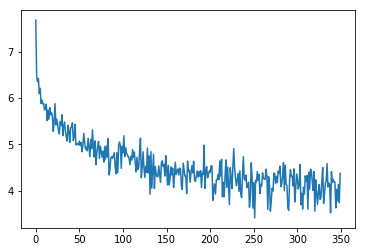

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### 调整“混乱度”

上面遗留了一个“混乱度”的问题。

混乱度的意义是这样的：

当混乱度太低时，RNN 模型就趋向于选择“概率最大的下一个字”，注意哦！概率最大不代表效果最好。因为 RNN 模型是用固定的嘻哈歌词训练的，每次都选择“概率最大的下一个字”，意味着每次输出的值都一样。

In [31]:
print(evaluate('药药切克闹', 80, temperature=0.2))

药药切克闹
我们在一边的
我们的
我们的
我们的
我们的
我们的
我们
我们的
我们的
我们都是你的
我们都是我的
我们
我们都是我的
我们都是我的
我需要你的
我们
你


当混乱度太高时，RNN 模型趋向于选择“概率不大的下一个字”，实际产生的效果与随机选择类似，就像 RNN 模型没经过训练时的样子似的。

可以观察到“混乱度”太高时生成的嘻哈歌词几乎没有意义。

In [32]:
print(evaluate('药药切克闹', 80, temperature=1.4))

药药切克闹
学影愿这怒尸市
骆驼眼儿房降临
我意内来犯錯它低手话
沉灭电风枉天雾大自己善技能夠走掉梦变的生魂
垮青靠为每扯查幻都来说棋
直到欺
白边已工队放切不是爷英先



当混乱度适中，才能生成较好的嘻哈歌词，既不会千篇一律，也不会出现每个字前后没有关联的情况。

In [39]:
print(evaluate('我的世界', 100, temperature=0.8))

我的世界
有铜磨灭
有我锤子事事情不止给你说
第来觉得我把人民是我锤子事
跟我们看你的眼神都遭到了
把到哪一天天上起副糕
我不是通利福尼亚
艾夫杰尼
你用戴着德我的土鸡炖
我一起长到的地边
我能像梦想
快把雪


### 还可以改进的点

模型可以改进的地方还有很多。

第一，原始嘻哈歌词数据中包含有“英文歌词”，而我为了降低模型训练难度直接去掉了这些“英文歌词”。没有英文歌词的衔接，原歌词中有些句子转折会比较生硬，这也是模型最后生成的嘻哈歌词有时候衔接生硬的原因。

可以将原数据中的“整句英文歌词”视为“一个字”，给予映射成一个字向量，进行训练和生成。

第二，嘻哈说唱的灵魂是押韵！我们这次只考虑了“字”，没有考虑“音”。

“xpinyin”可以将文字转化为拼音。将押韵考虑进去可以打造生成双押韵乃至三押韵的嘻哈歌词模型，这也是我的“AI 有嘻哈2.0”计划！

### 课后作业

学习曲线波动率很大不是？尝试一下更小的学习率？

增加迭代次数、增加隐藏层层数、调整隐藏层单元数能够改进模型吗？

这是你的 FreeStyle 时间！

![](http://wiki.swarma.net/images/c/ca/AI学园.jpg)